Using Colab cache for faster access to the 'customer-personality-analysis' dataset.
--- Baseline KNN (K=5) Performance ---
Accuracy: 0.9617

Classification Report:
                   precision    recall  f1-score   support

Standard Spender       0.95      0.97      0.96       222
    High Spender       0.97      0.95      0.96       222

        accuracy                           0.96       444
       macro avg       0.96      0.96      0.96       444
    weighted avg       0.96      0.96      0.96       444



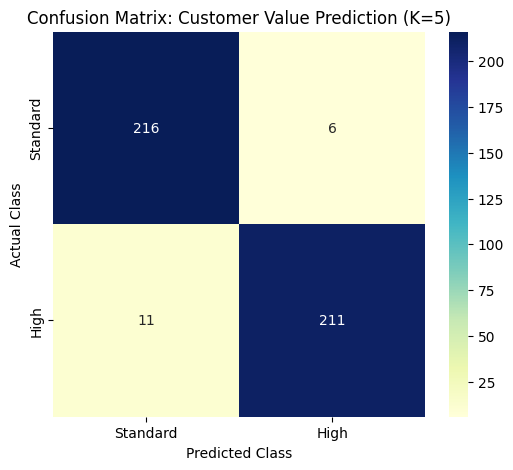

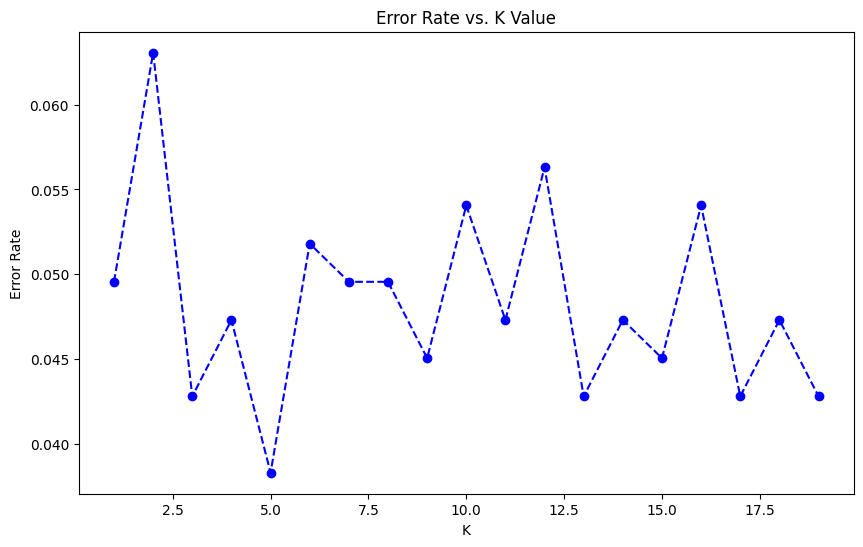

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# =========================
# 1. Load Data
# =========================
# Download the Customer Personality Analysis dataset
path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")
# The dataset is typically in a .tsv (tab-separated) format
csv_file = [f for f in os.listdir(path) if f.endswith('.csv') or f.endswith('.tsv')][0]
df = pd.read_csv(os.path.join(path, csv_file), sep='\t')

# =========================
# 2. Preprocessing
# =========================
# Create a binary target: "High Spender" (1) if total spent > median, else (0)
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spent'] = df[spending_cols].sum(axis=1)
df['Target'] = (df['Total_Spent'] > df['Total_Spent'].median()).astype(int)

# Select numerical features and drop rows with missing values (e.g., Income)
df_numeric = df.select_dtypes(include=[np.number]).dropna()

# Drop ID and target-related columns from features
X = df_numeric.drop(['ID', 'Total_Spent', 'Target'], axis=1)
y = df_numeric['Target']

# =========================
# 3. Scaling (CRITICAL FOR KNN)
# =========================
# KNN uses Euclidean distance; scaling prevents features with large ranges
# (like Income) from dominating features with small ranges (like Kidhome).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# 4. Split Data
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================
# 5. Train Baseline Model (K=5)
# =========================
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# =========================
# 6. Performance Metrics
# =========================
print("--- Baseline KNN (K=5) Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Standard Spender', 'High Spender']))

# Visualization: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            cmap='YlGnBu',
            fmt='d',
            xticklabels=['Standard', 'High'],
            yticklabels=['Standard', 'High'])
plt.title('Confusion Matrix: Customer Value Prediction (K=5)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# =========================
# 7. Finding Optimal K (Elbow Method)
# =========================
error_rate = []
for i in range(1, 20):
    knn_i = KNeighborsClassifier(n_neighbors=i)
    knn_i.fit(X_train, y_train)
    pred_i = knn_i.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), error_rate, color='blue', linestyle='dashed', marker='o')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()